In [11]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'assignment4'
FOLDERNAME = 'cs6353/assignments/assignment4/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

run the following from the cs6353 directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs6353/assignments/assignment4/cs6353/datasets
--2024-12-12 21:30:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  27.1MB/s    in 6.0s    

2024-12-12 21:30:24 (27.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-1

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [12]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs6353.classifiers.fc_net import *
from cs6353.data_utils import get_CIFAR10_data
from cs6353.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs6353.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# You can ignore the message that asks you to run Python script for now.
# It will be required in the second part of the assignment.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs6353/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [14]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.75, 0.6, 0.3]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.75
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.3
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs6353/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [15]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8929028107279455e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:

If we don't divide the activations by 𝑝 during the forward pass of dropout, the output will be smaller during training because some neurons are randomly set to zero. For example, let's say we have 10 neurons in a layer and 𝑝 = 0.5. This means that, on average, half of the neurons will be dropped, and only the other half will remain active. As a result, the remaining activations will, on average, be half of their original value. Without scaling by 1/𝑝, this would lead to a reduced signal, which can affect the learning process, causing slower convergence.

Dividing by 𝑝 compensates for this reduction by scaling the remaining activations. So, in our example with 𝑝 = 0.5, the non-dropped activations are multiplied by 1/0.5 = 2, effectively doubling the activations of the remaining neurons. This ensures that the expected sum of the activations during training is the same as it would be without dropout. By doing this, we maintain a consistent signal and allow the model to learn at the same rate as it would if no dropout were applied.

So during testing, when no neurons are dropped, no scaling is needed because the activations are already at their full value. Therefore, scaling during training ensures consistency between the two phases and prevents performance discrepancies.








# Fully-connected nets with Dropout
In the file `cs6353/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 0 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [16]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout = 0 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.300479089768492
W1 relative error: 1.03e-07
W2 relative error: 2.21e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.69e-10

Running check with dropout =  0.25
Initial loss:  2.302371489704412
W1 relative error: 1.85e-07
W2 relative error: 2.15e-06
W3 relative error: 4.56e-08
b1 relative error: 1.16e-08
b2 relative error: 1.82e-09
b3 relative error: 1.48e-10

Running check with dropout =  0.5
Initial loss:  2.30427592207859
W1 relative error: 3.11e-07
W2 relative error: 2.48e-08
W3 relative error: 6.43e-08
b1 relative error: 5.37e-09
b2 relative error: 1.91e-09
b3 relative error: 1.85e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [17]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.880000; val_acc: 0.268000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.277000
(Epoch 10 / 25) train acc: 0.898000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.924000; val_acc: 0.263000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.300000
(Epoch 13 / 25) train acc: 0.972000; val_acc: 0.314000
(Epoch 14 / 25) train acc: 0.972000; val_acc: 0.310000
(Epoch 15 / 25) train acc: 0.974000; val_acc: 0.314000
(Epoch 16 / 25) train acc: 0.994000; val_acc: 0.303000
(Epoch 17 / 25) train acc: 0.970000; v

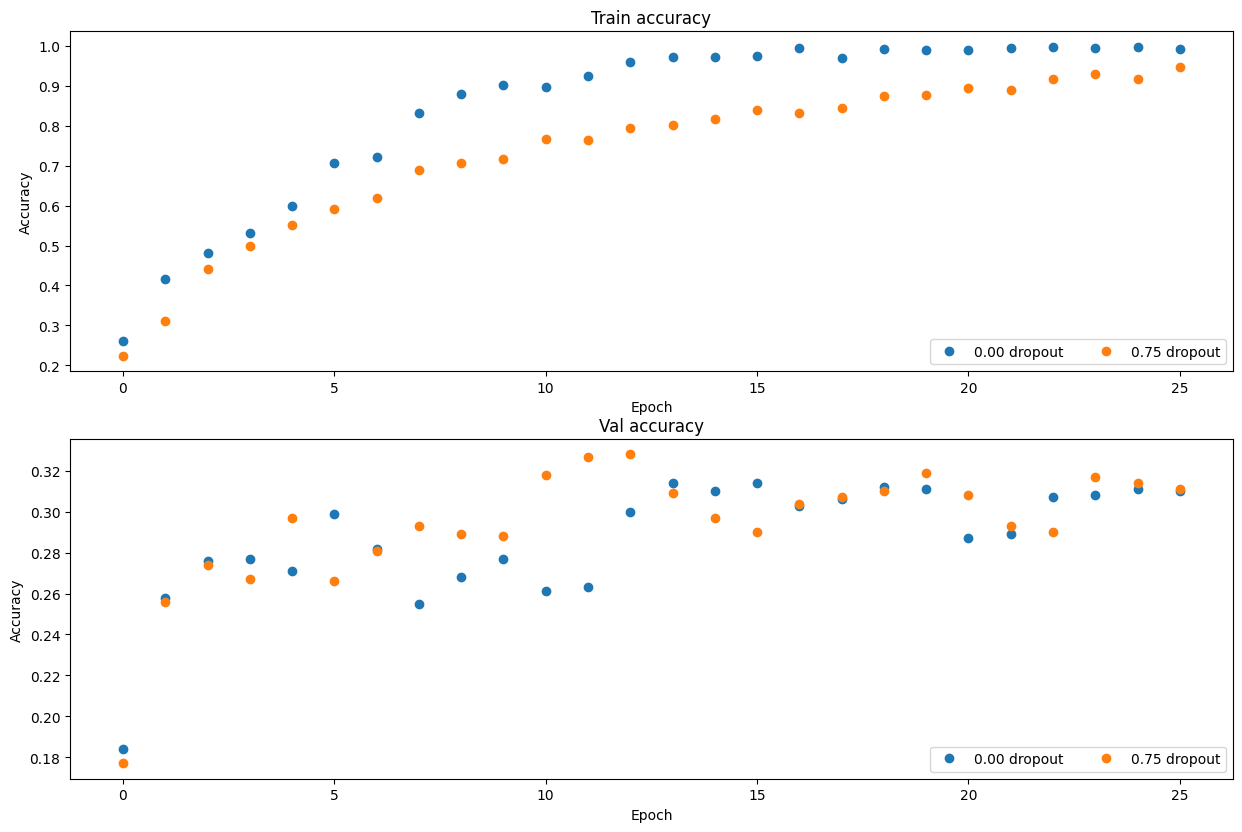

In [ ]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:

1. Training Accuracy Comparison:

  * Without Dropout (0.00 dropout): The model without dropout shows a rapid increase in training accuracy, which is expected. Since the model isn't regularized, it can memorize the training data faster, leading to high accuracy on the training set. However, this comes with the risk of overfitting, where the model learns to fit the noise or irrelevant patterns in the data rather than generalize well to new, unseen data.

  * With Dropout (0.75 dropout): The model with dropout shows a slower increase in training accuracy. Dropout works by randomly "dropping" (i.e., deactivating) a fraction of the neurons during each training iteration, which prevents the model from becoming overly reliant on any single feature or part of the network. As a result, the training process is noisier, and the model doesn't memorize the training data as quickly. This slowdown in training is a natural consequence of the regularization effect that dropout introduces.

2. Validation Accuracy Comparison:

  * Without Dropout: The validation accuracy for the model without dropout tends to plateau or even decrease as training progresses. This suggests that while the model performs well on the training data, it struggles to generalize to new, unseen data, leading to overfitting. Overfitting occurs when the model has learned too much detail from the training data, including noise or irrelevant patterns, which hurts its performance on the validation set.

  * With Dropout: The model with dropout, although initially slower to train, shows a much steadier increase in validation accuracy. This is because dropout forces the model to learn more robust features that generalize better to unseen data. It prevents the network from becoming too specialized in certain patterns in the training data, making it more flexible and capable of handling new data better. As a result, dropout helps the model generalize better, preventing overfitting and leading to a more stable and consistent improvement in validation accuracy.

3. Results:

  * Prevention of Overfitting: The key takeaway is that dropout helps prevent overfitting. While the model without dropout shows rapid improvements in training accuracy, it also fails to maintain a similar level of performance on the validation set, which is a classic sign of overfitting. The model with dropout, on the other hand, shows more consistent and gradual improvements in validation accuracy, suggesting better generalization.

  * Slower Training, But Better Generalization: Dropout results in a slower rate of increase in training accuracy, which might seem like a disadvantage at first. However, this is a small price to pay for the long-term benefits of better generalization to new data. By introducing noise during training (by dropping units randomly), the model doesn't memorize the training data, making it more likely to perform well on unseen data.

  * Dropout as a Regularization Tool: Dropout acts as a form of regularization by reducing the capacity of the model to overfit. This means that even with a large number of parameters or layers in the network, the model will not rely too heavily on any single parameter or neuron, which can lead to better performance in terms of validation accuracy.

4. Trade-Off Between Training and Validation Performance: Although the model with dropout takes longer to train and shows slightly slower increases in training accuracy, it leads to better generalization. This indicates that while the model with dropout might seem less "perfect" during training, it ultimately results in a more robust model that is more capable of handling real-world data.

## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by dropout probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:

When reducing the size of hidden layers in a deep fully-connected network, you should decrease the dropout probability (p). Smaller hidden layers have fewer neurons, which means the network has less capacity to overfit the data. As a result, the model may not require as much regularization as with larger hidden layers.

A smaller p (e.g., 0.2 to 0.4) is appropriate because it provides enough regularization without overly restricting the network's ability to learn. If you use the same p value as for larger networks, you may end up with too much regularization, which can hinder the model’s learning process.

Thus, decreasing the hidden layer size generally calls for a lower dropout probability (p) to match the reduced capacity of the model.